In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import seaborn as sns

In [3]:
# Read CSVs
PatientConsumption = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders    = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders   = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs        = pd.read_csv('Diccionario_v3.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)

date_columns   = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns   = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)

___
## Time series

In [4]:
TopMeds=['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
        'FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER)',
        'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
        'SOMAZINA 1G AMP 4ML (CITICOLINA)',
        'INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)',
        'MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL',
        'VANCOCIN CP 1G AMP (VANCOMICINA)',
        'COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATRO./ SALBUTAMOL',
        'LIPITOR 80MG C/30 TAB(ATORVASTATINA)']

In [5]:
# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')

In [6]:
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']

df[(df['AmountPurchased']!=df['AmountReceived']) & (df['AmountRequested']!=df['AmountPurchased'])].head()

,YearMonth,RequestNumber,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
438,2018-01-01,52936,3300586,1,2,0.0,1.0
677,2018-01-01,53062,3300627,10,19,1.0,9.0
717,2018-01-01,53076,3300952,15,30,0.0,15.0
1975,2018-03-01,53801,3305045,20,270,0.0,20.0
2069,2018-03-01,53877,3300072,18,20,0.0,18.0


In [7]:
AmountOrder = df.groupby(['YearMonth','MedCode']).sum()[['AmountRequested','AmountPurchased','AmountReceived','AmountMissing']].reset_index()
AmountOrder.head(5)

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
0,2018-01-01,1000268,15,18,18.0,-3.0
1,2018-01-01,2900193,2,2,2.0,0.0
2,2018-01-01,2900517,7,6,5.0,2.0
3,2018-01-01,3300018,2,2,0.0,2.0
4,2018-01-01,3300029,1,1,1.0,0.0


In [8]:
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed.head()

,YearMonth,MedCode,AmountConsumed
0,2018-01-01,1000268.0,22
1,2018-01-01,2900193.0,2
2,2018-01-01,2900517.0,3
3,2018-01-01,3300018.0,1
4,2018-01-01,3300029.0,1


In [9]:
MonthlyMeds = pd.merge(AmountOrder, AmountConsumed, on=['YearMonth','MedCode'], how='outer')
# fill AmountConsumed.isna() with zeros
#MonthlyMeds['AmountConsumed'] = MonthlyMeds['AmountConsumed'].fillna(0)
MonthlyMeds = MonthlyMeds.fillna(0)
MonthlyMeds.head()

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed
0,2018-01-01,1000268,15.0,18.0,18.0,-3.0,22.0
1,2018-01-01,2900193,2.0,2.0,2.0,0.0,2.0
2,2018-01-01,2900517,7.0,6.0,5.0,2.0,3.0
3,2018-01-01,3300018,2.0,2.0,0.0,2.0,1.0
4,2018-01-01,3300029,1.0,1.0,1.0,0.0,1.0


In [10]:
MonthlyMeds = pd.merge(MonthlyMeds, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')
MonthlyMeds.head(5)

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,MedDescription
0,2018-01-01,1000268,15.0,18.0,18.0,-3.0,22.0,HALOPERIL 5MG/ML AMP IM (HALOPERIDOL)
1,2018-01-01,2900193,2.0,2.0,2.0,0.0,2.0,REFRESH TEARS GTS 15ML (CARBOXIMETILCELULOSA S...
2,2018-01-01,2900517,7.0,6.0,5.0,2.0,3.0,ALBUMINA DE HUEVO 400GR OVOPROT
3,2018-01-01,3300018,2.0,2.0,0.0,2.0,1.0,LYRICA 150MG C/14 TAB(PREGABALINA)
4,2018-01-01,3300029,1.0,1.0,1.0,0.0,1.0,ADIMOD SOLUCION 800MG/7ML CAJA C/10 FCO (PIDOT...


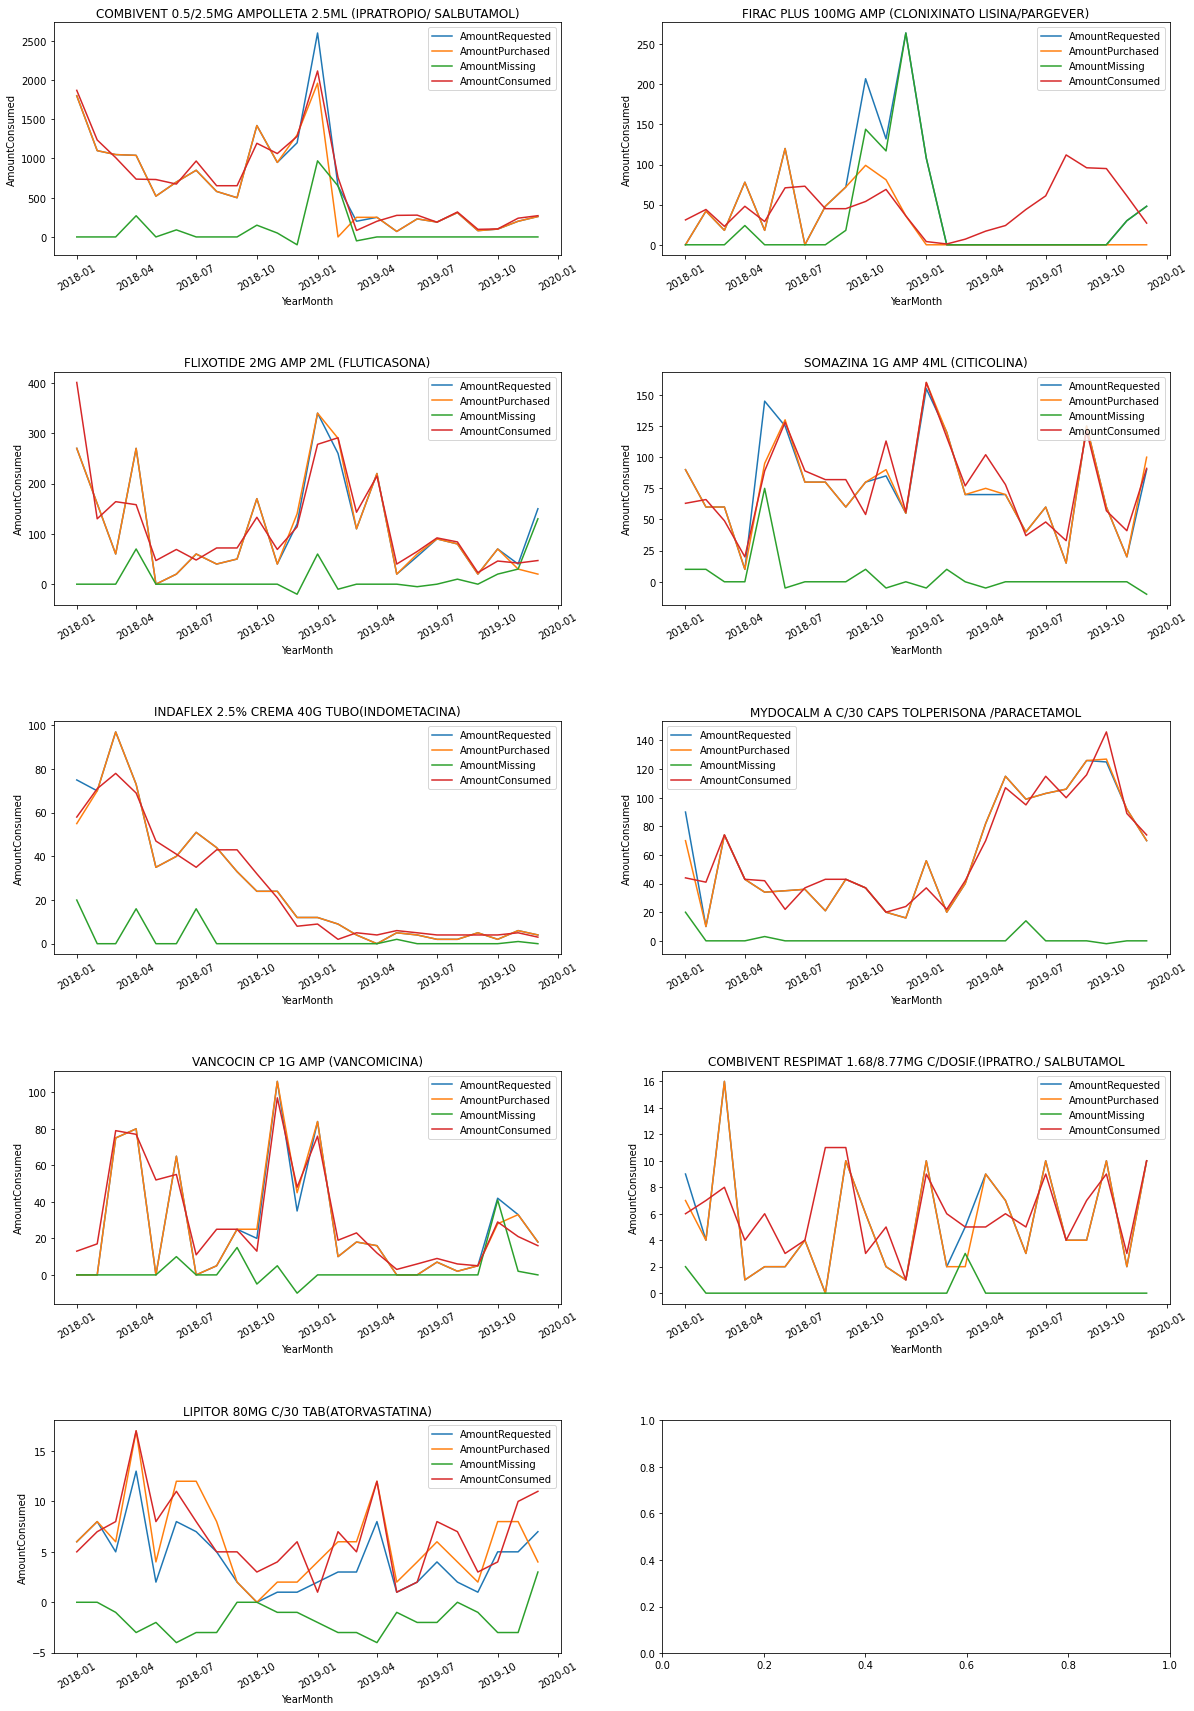

In [11]:
# Plot top Meds
fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, MedCode in zip(axes.flatten(), TopMeds):
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountRequested', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountPurchased', ax=ax)
    #sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountMissing', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    #ax.legend(["AmountRequested","AmountPurchased",'AmountReceived','AmountMissing','AmountConsumed'])
    ax.legend(["AmountRequested","AmountPurchased",'AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)

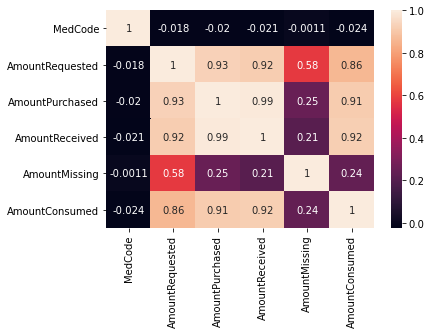

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(data=MonthlyMeds.corr(), annot=True);

___

In [20]:
top_meds = MonthlyMeds[MonthlyMeds["MedDescription"].isin(TopMeds)].sort_values(['MedCode','YearMonth']).reset_index(drop=True)
top_meds

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,MedDescription
0,2018-01-01,3300115,75.0,55.0,55.0,20.0,58.0,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)
1,2018-02-01,3300115,70.0,70.0,70.0,0.0,71.0,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)
2,2018-03-01,3300115,97.0,97.0,97.0,0.0,78.0,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)
3,2018-04-01,3300115,73.0,73.0,57.0,16.0,69.0,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)
4,2018-05-01,3300115,35.0,35.0,35.0,0.0,47.0,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)
...,...,...,...,...,...,...,...,...
211,2019-08-01,3500322,106.0,106.0,106.0,0.0,100.0,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL
212,2019-09-01,3500322,126.0,126.0,126.0,0.0,116.0,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL
213,2019-10-01,3500322,125.0,127.0,127.0,-2.0,146.0,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL
214,2019-11-01,3500322,92.0,92.0,92.0,0.0,89.0,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL


In [21]:
PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]

,MedCode,MedDescription,Compound,MedFamily,MedPriceMXN,MinStock,MaxStock
14,3300115,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA),INDOMETACINA,Sistema musculoesquelético,719.0,21,59
37,3300142,LIPITOR 80MG C/30 TAB(ATORVASTATINA),ATORVASTATINA,Sistema cardiovascular,801.0,5,13
202,3300663,VANCOCIN CP 1G AMP (VANCOMICINA),VANCOMICINA,Antiinfecciosos para uso sistémico,1059.0,26,74
517,3301778,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),FLUTICASONA,Sistema respiratorio,720.5,118,306
548,3301771,SOMAZINA 1G AMP 4ML (CITICOLINA),CITICOLINA,Sistema nervioso,209.5,55,125
631,3302307,FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGE...,CLONIXINATO LISINA/PARGEVER,Tracto alimentario y metabolismo,152.5,29,84
795,3302934,COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATR...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,669.5,4,8
1495,3500322,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL,MYDOCALM,Sistema musculoesquelético,613.0,52,114
1585,3302669,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,528.5,591,1608


___
# Timeseries prediction model

In [115]:
import tensorflow as tf
import matplotlib as mpl

In [116]:
tf.random.set_seed(42)

In [131]:
'''
MedFamily = PatentDrugs[PatentDrugs['MedFamily']=='Sistema respiratorio']['MedCode']
MonthlyFamily = MonthlyMeds[MonthlyMeds['MedCode'].isin(MedFamily)]
NumMonths     = MonthlyFamily.groupby(['MedCode','YearMonth']).count().reset_index().groupby('MedCode').count().sort_values('YearMonth', ascending=False)
NumMonths24   = NumMonths[NumMonths['YearMonth']==24].index.values
NumMonths24
'''

NumMonths     = MonthlyMeds.groupby(['MedCode','YearMonth']).count().reset_index().groupby('MedCode').count().sort_values('YearMonth', ascending=False)
NumMonths24   = NumMonths[NumMonths['YearMonth']==24].index.values
NumMonths24.shape

(87,)

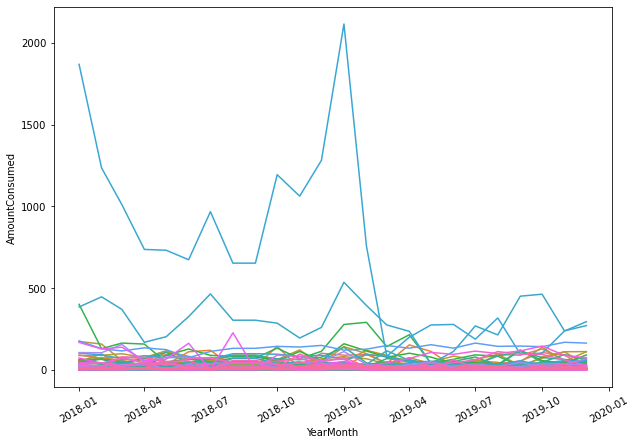

In [133]:
MedFamily24 = MonthlyMeds[MonthlyMeds['MedCode'].isin(NumMonths24)]
plt.figure(figsize=(10,7))
sns.lineplot(data=MedFamily24, x='YearMonth', y='AmountConsumed', hue='MedDescription', legend=False)
plt.xticks(rotation=30);

In [134]:
uni_data = MedFamily24.set_index('MedCode')['AmountConsumed']

uni_data_norm = []
for i, MedCode in enumerate(uni_data.index.unique()):
    chunk = uni_data[uni_data.index==MedCode].values
    chunk = (chunk - chunk.mean()) / chunk.std()
    chunk.reshape(len(chunk),1)
    uni_data_norm.append(chunk)

uni_data_norm = np.array(uni_data_norm)
print(uni_data_norm.shape)

(87, 24)


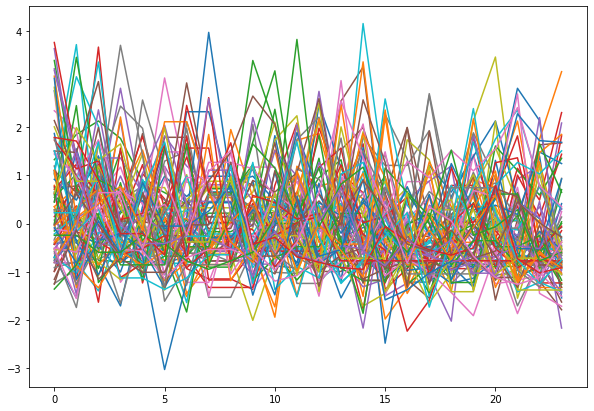

In [135]:
plt.figure(figsize=(10,7))
for i in range(uni_data_norm.shape[0]):
    sns.lineplot(data=uni_data_norm[i]);

In [137]:
# train & validation splits

TRAIN_SPLIT = 80

length = uni_data_norm.shape[1]
x_train_uni = []
y_train_uni = []
x_val_uni = []
y_val_uni = []

for Med in range(uni_data_norm.shape[0]):
    if Med < TRAIN_SPLIT:
        x_train_uni.append(uni_data_norm[Med][:length-1].reshape(length-1,1))
        y_train_uni.append(uni_data_norm[Med][length-1])
    else:
        x_val_uni.append(uni_data_norm[Med][:length-1].reshape(length-1,1))
        y_val_uni.append(uni_data_norm[Med][length-1])

x_train_uni = np.array(x_train_uni)
y_train_uni = np.array(y_train_uni)
x_val_uni = np.array(x_val_uni)
y_val_uni = np.array(y_val_uni)

print(x_train_uni.shape, y_train_uni.shape)
print(x_val_uni.shape, y_val_uni.shape)
#x_valid_uni = 
#y_valid_uni = 

(80, 23, 1) (80,)
(7, 23, 1) (7,)


In [138]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target value to predict')
print (y_train_uni[0])

Single window of past history
[[-0.71272927]
 [ 1.55123429]
 [ 0.04192525]
 [-0.67080402]
 [-0.167701  ]
 [-0.83850502]
 [-0.67080402]
 [ 0.        ]
 [ 0.        ]
 [ 0.88043027]
 [-0.88043027]
 [-0.92235552]
 [ 0.33540201]
 [-0.29347676]
 [-0.0838505 ]
 [-0.0838505 ]
 [-1.21583228]
 [-1.21583228]
 [ 0.33540201]
 [-0.0838505 ]
 [ 0.67080402]
 [ 2.80899182]
 [ 2.1381878 ]]

 Target value to predict
-0.9223555225481652


In [148]:
BATCH_SIZE = 1
BUFFER_SIZE = 1

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [149]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
        tf.keras.layers.Dense(1)
    ])

model.compile(optimizer='adam', loss='mae')

In [150]:
EPOCHS = 10
EVALUATION_INTERVAL = 200

model.fit(train_univariate, epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 10s 52ms/step - loss: 0.8228 - val_loss: 0.5255
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.7075 - val_loss: 0.5008
Epoch 3/10
200/200 [==============================] - 5s 27ms/step - loss: 0.7092 - val_loss: 0.5055
Epoch 4/10
200/200 [==============================] - 6s 30ms/step - loss: 0.6809 - val_loss: 0.4772
Epoch 5/10
200/200 [==============================] - 5s 25ms/step - loss: 0.6756 - val_loss: 0.4812
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6322 - val_loss: 0.4108
Epoch 7/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6432 - val_loss: 0.4822
Epoch 8/10
200/200 [==============================] - 5s 25ms/step - loss: 0.5975 - val_loss: 0.4174
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.6106 - val_loss: 0.4131
Epoch 10/10
200/200 [==========================

In [151]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                             label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

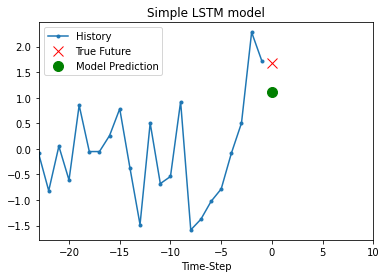

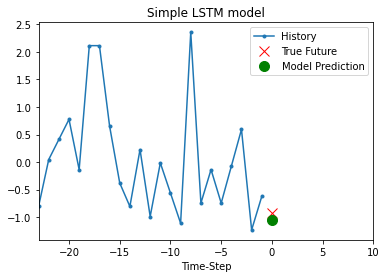

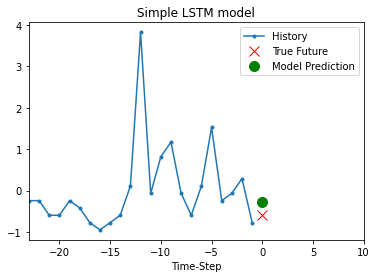

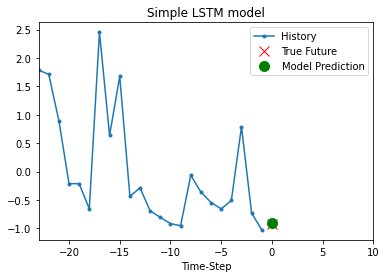

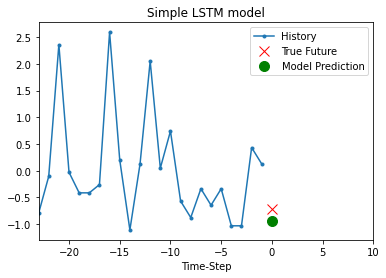

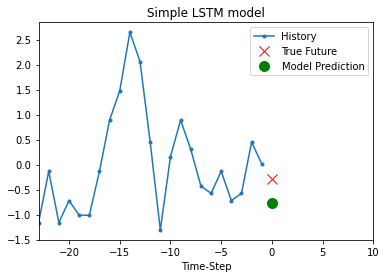

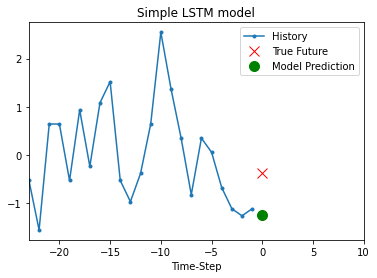

In [153]:
for x, y in val_univariate.take(7):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()